# Pokemon type classification based on their stats

The purpose of this project is to make a classification prediction on the type of a Pokemon given his stats. This project is inspired from a Youtube video you could find here: https://www.youtube.com/watch?v=0xVqLJe9_CY and is the result of my first steps in Classification.

Given that this is a classification problem, we will train different algorithms and see which one performs the best. 
We will train 3 models: SVC, logistic regression and  random forest.



This is not for any homework / assignment, it's just for personnal practice

## I - Importing the libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, roc_curve, precision_score, recall_score, confusion_matrix


## II - Loading the data

In [2]:
ls

 Le volume dans le lecteur C n'a pas de nom.
 Le num‚ro de s‚rie du volume est C249-2CA7

 R‚pertoire de C:\Users\User\MLResources\Projet perso\Pokemon

04/12/2019  19:11    <DIR>          .
04/12/2019  19:11    <DIR>          ..
24/11/2019  21:13    <DIR>          .ipynb_checkpoints
18/12/2016  01:50            44ÿ028 Pokemon.csv
04/12/2019  19:11           741ÿ877 Pokemon.ipynb
               2 fichier(s)          785ÿ905 octets
               3 R‚p(s)  171ÿ052ÿ032ÿ000 octets libres


In [3]:
df = pd.read_csv("Pokemon.csv")
print(df.shape)
df.head()

(800, 13)


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


As we can see we have a small dataset with only 800 rows, and 13 features. 

## III - Exploratory data analysis

In [4]:
df.dtypes

#              int64
Name          object
Type 1        object
Type 2        object
Total          int64
HP             int64
Attack         int64
Defense        int64
Sp. Atk        int64
Sp. Def        int64
Speed          int64
Generation     int64
Legendary       bool
dtype: object

The first look at this dataset make me think that i will for the first part of this project only assume pokemon can have one type at a time. We will then improve our project and models to take the secondary type into account.
Also we will need to create a class for each pokemon type, for this i will create a target feature called target the gets values depending on the type.
But first let's have some insights about our features and check erros, missing values, etc...

In [5]:
print(df['Type 1'].value_counts())
df['Type 1'].value_counts().sum()

Water       112
Normal       98
Grass        70
Bug          69
Psychic      57
Fire         52
Electric     44
Rock         44
Dragon       32
Ghost        32
Ground       32
Dark         31
Poison       28
Steel        27
Fighting     27
Ice          24
Fairy        17
Flying        4
Name: Type 1, dtype: int64


800

In [6]:
print(df['Type 2'].value_counts())
df['Type 2'].value_counts().sum()

Flying      97
Ground      35
Poison      34
Psychic     33
Fighting    26
Grass       25
Fairy       23
Steel       22
Dark        20
Dragon      18
Water       14
Ice         14
Ghost       14
Rock        14
Fire        12
Electric     6
Normal       4
Bug          3
Name: Type 2, dtype: int64


414

In [7]:
df.describe()

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,362.813750,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,208.343798,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,1.000000,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,184.750000,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,364.500000,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,539.250000,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,721.000000,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


In [8]:
missing = df.isnull().sum()
missing

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

There are several interesting informations here:
- While all pokemon have a type 1, almost half of them have a second one, this is something we will need to take care of when treating the second type.
- A direct consequence of this first insight is that some types are over represented in the type 2 and not in the type 1 such as the Flying type 4 type 1 and 97 type 2 and the Normal type, with 98 type 1 and 4 type 2.
- We have a clean dataset with only the type 2 missing on some Pokemon, which is not surprising because some pokemon do not have a second type.
- We can notice that there are 800 rows but the pokemon's id represented by the feature # has a maximum value of 721, this is because of an ingame mecanic that acts as a duplicate of the pokemon in the dataset.
- Given the fact that our dataset has only 800 rows, we can anticipate the fact that our machine learning models are likely to underfit. We will try to mke some hyperparameters tuning. Even if it is likely to have close to no influence on our performance metrics.

Let's make some analysis to see if we can get some insights on the dataset


In [9]:
#functions to make analysis
def distrib(df, feature, title): 
    plt.figure(figsize=(25,10))
    sns.countplot(df[feature], order=df[feature].value_counts().index)
    plt.xlabel(feature)
    plt.title(title)
    plt.show()

def df_mean(df, var_agg, var_sort):
    df_agg = (df.groupby([var_agg]).mean().sort_values(var_sort, ascending=False))
    df_reset_index = df_agg
    df_reset_index.reset_index(level=0, inplace=True)
    return df_reset_index


def distrib_each_type(df, feat1, feat2, title):
    plt.figure(figsize=(25,10))
    sns.barplot(x = df[feat1], y = df[feat2], ci = None)
    plt.xlabel(feat1)
    plt.ylabel(feat2)
    plt.title(title)
    plt.show()
    



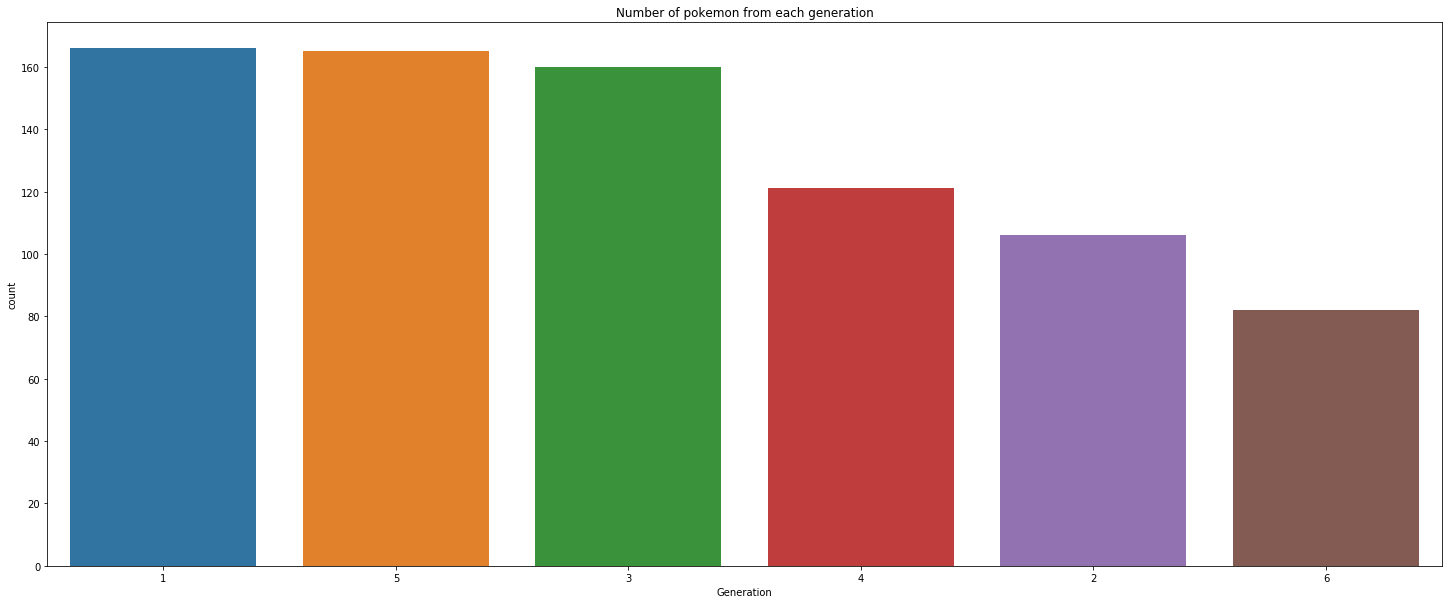

In [10]:
distrib(df, 'Generation', 'Number of pokemon from each generation')

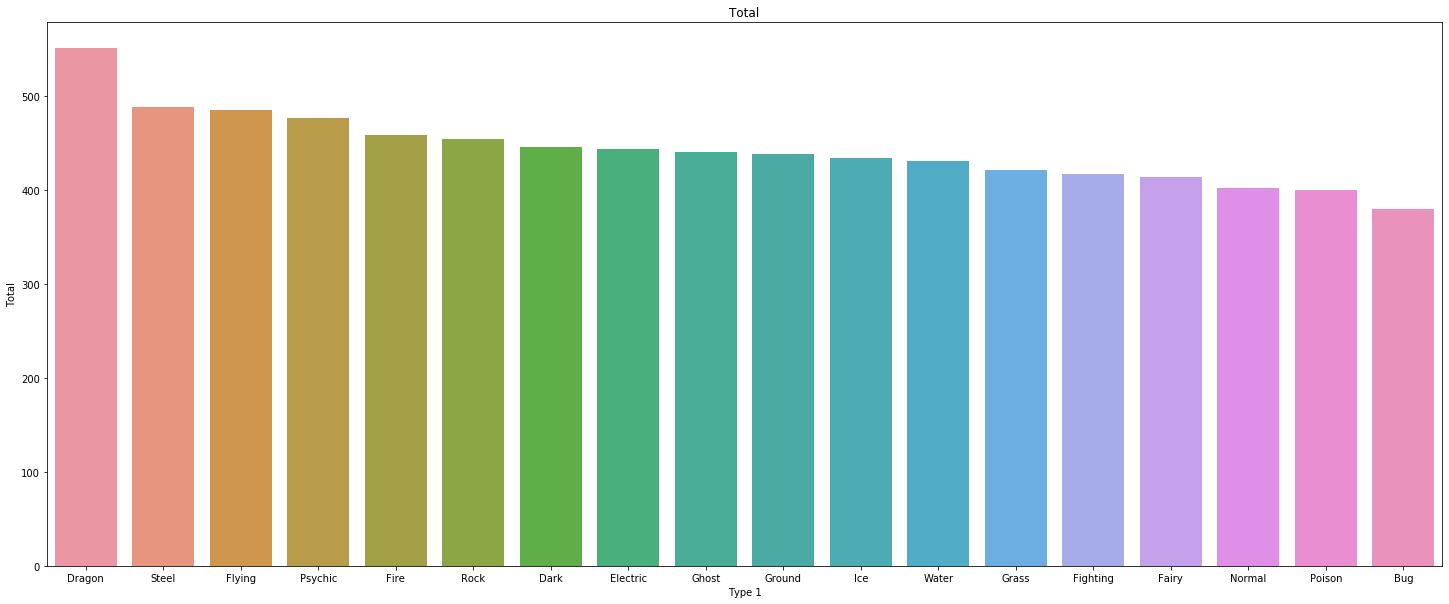

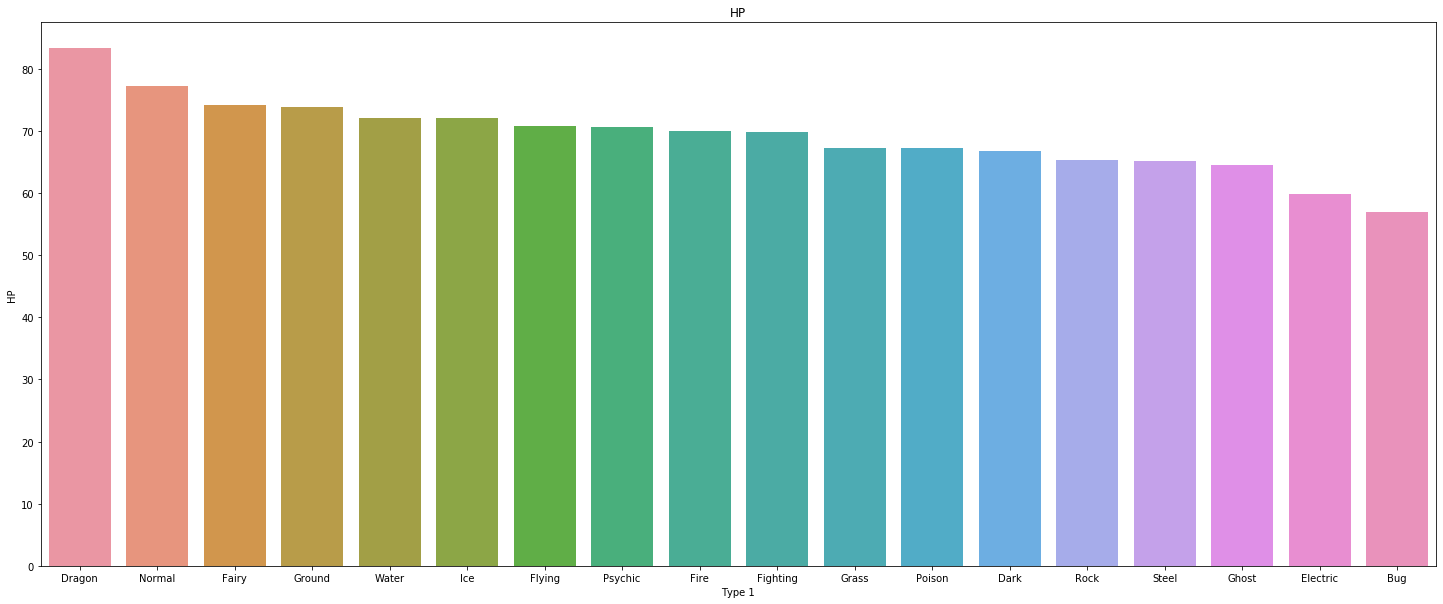

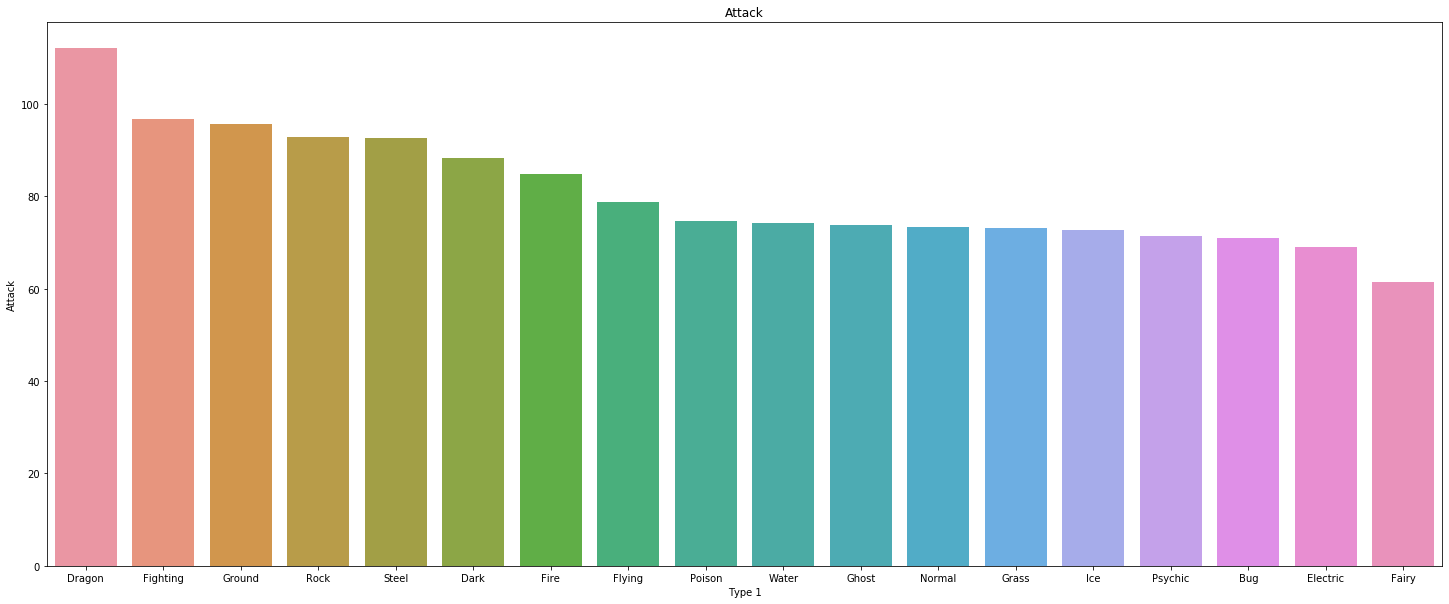

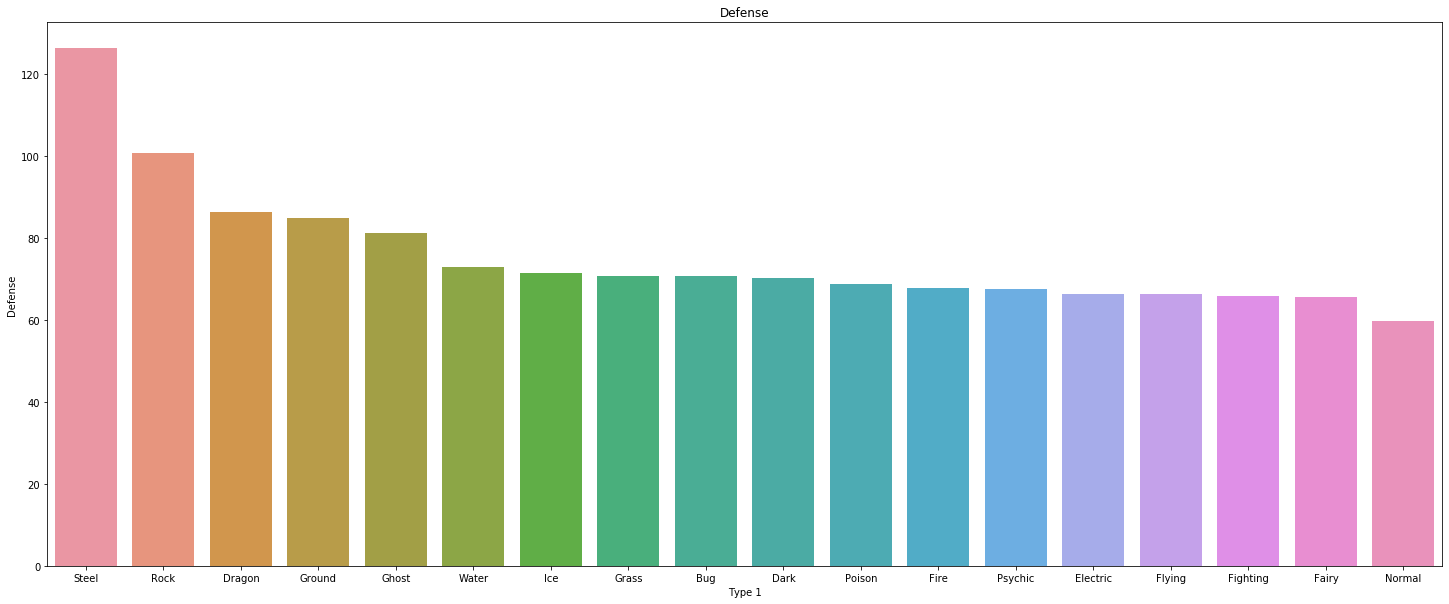

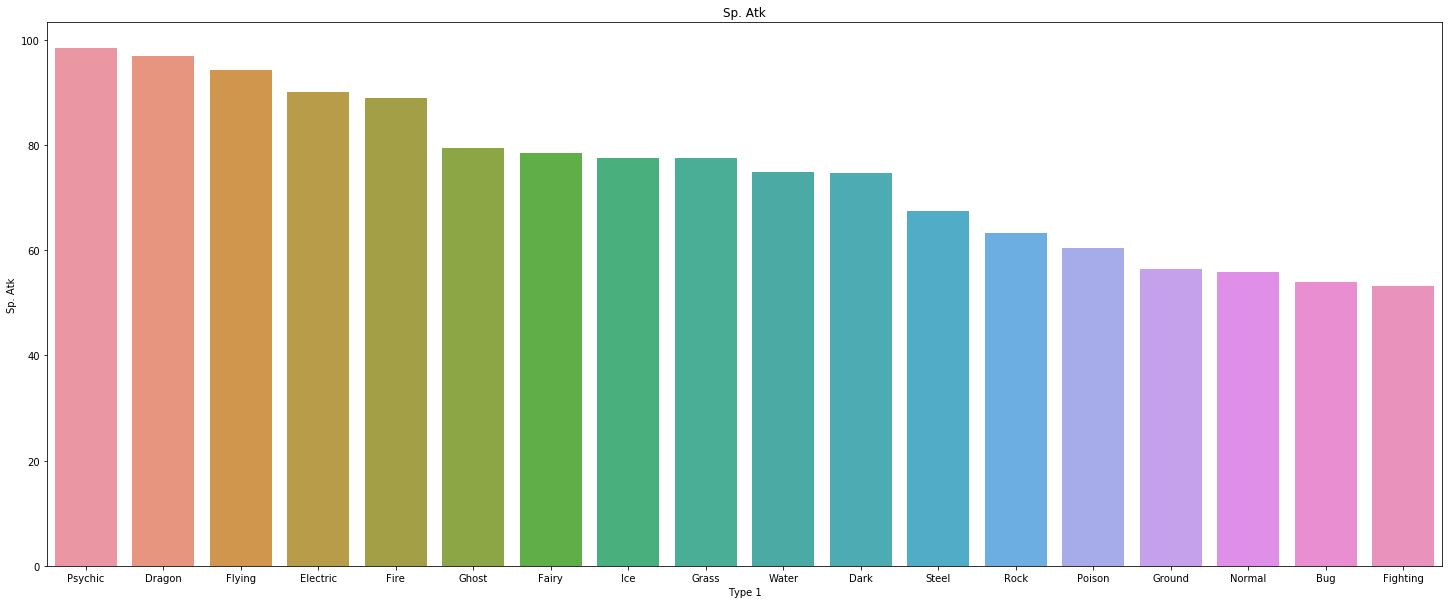

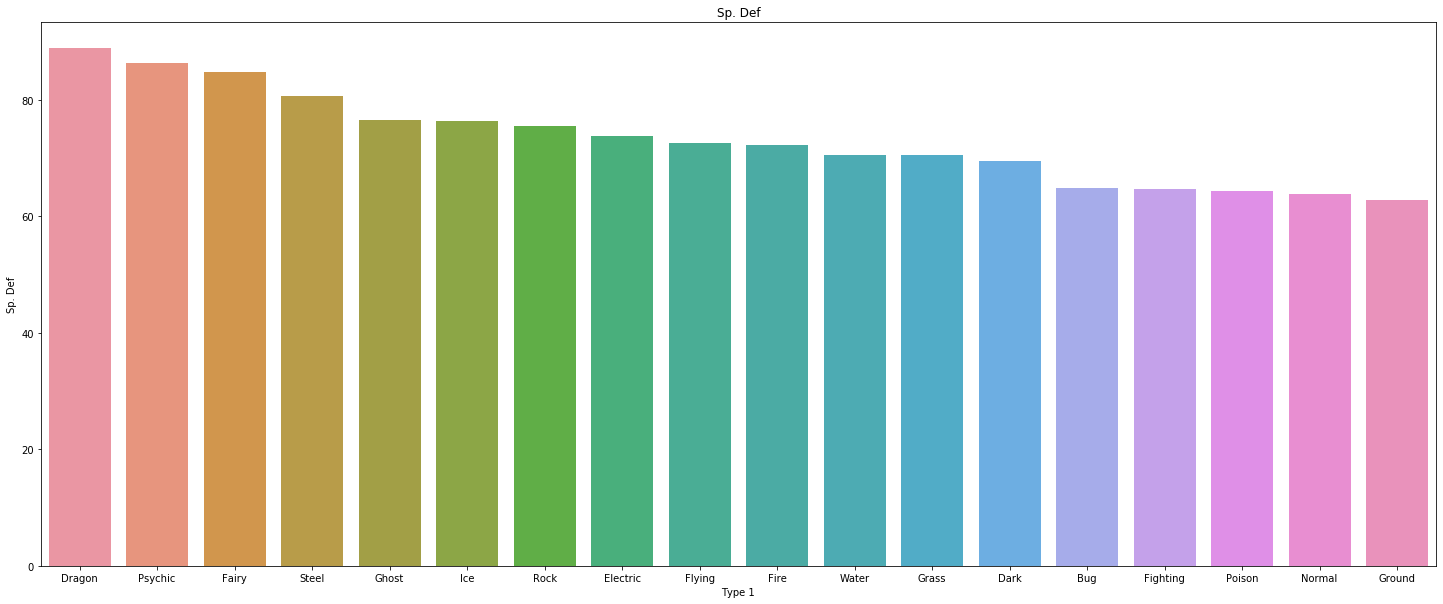

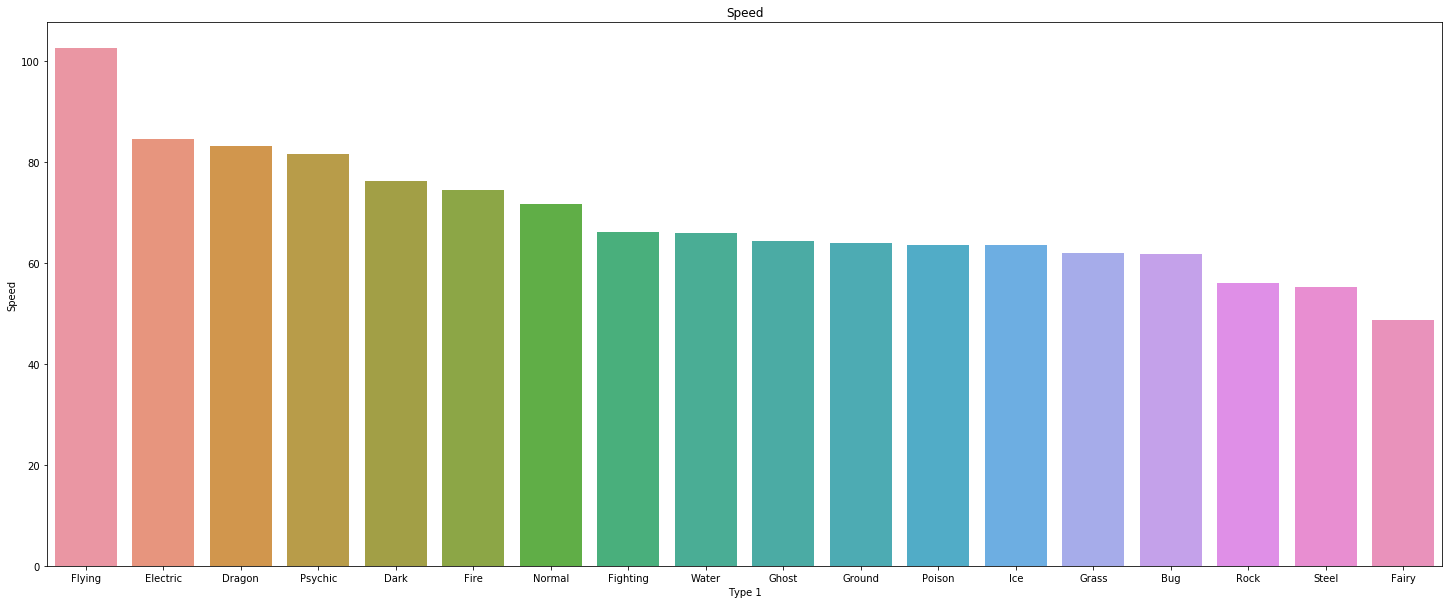

In [11]:
#looking for some stat representation in the type
stat_feats = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
for i in stat_feats:
    df_ordered = df_mean(df, 'Type 1', i)
    distrib_each_type(df_ordered, 'Type 1', i, '{}'.format(i))

We can notice that some types have specificities in their stat distributions that will help our models to make predictions.
For example Steel Type 1 Pokemon are more likely that others to have a high defense whereas Flying Type 1 Pokemon are likely ot have a high Speed.

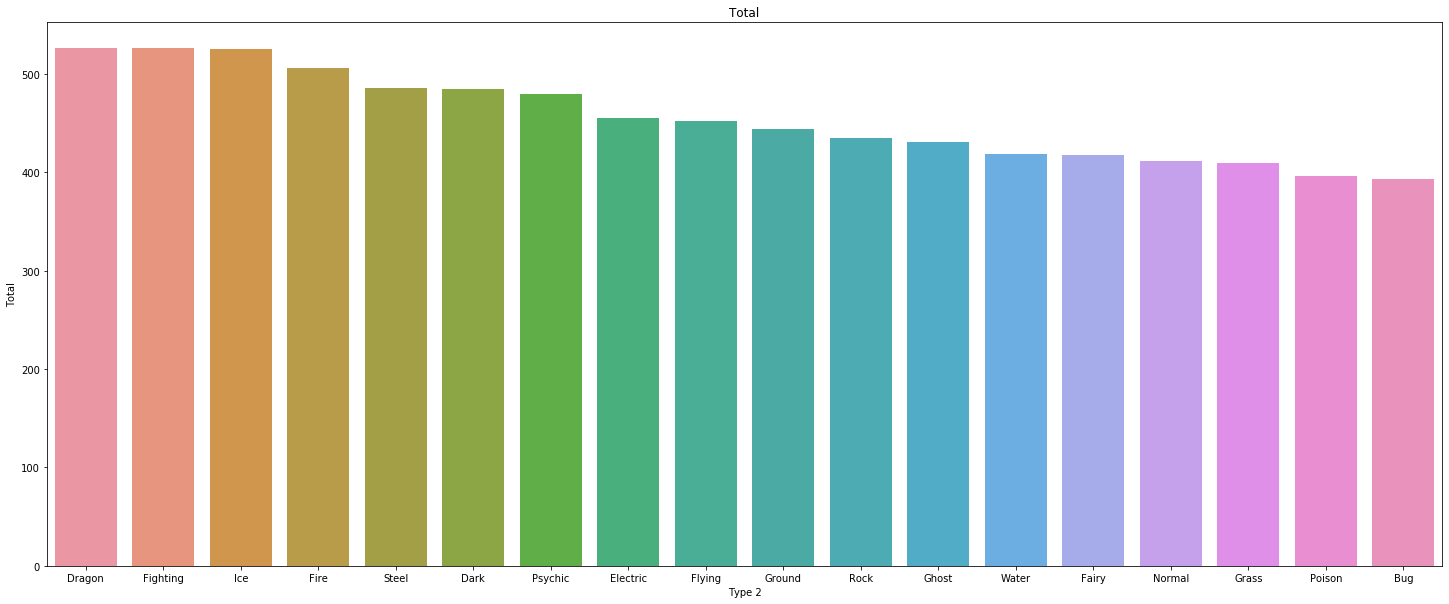

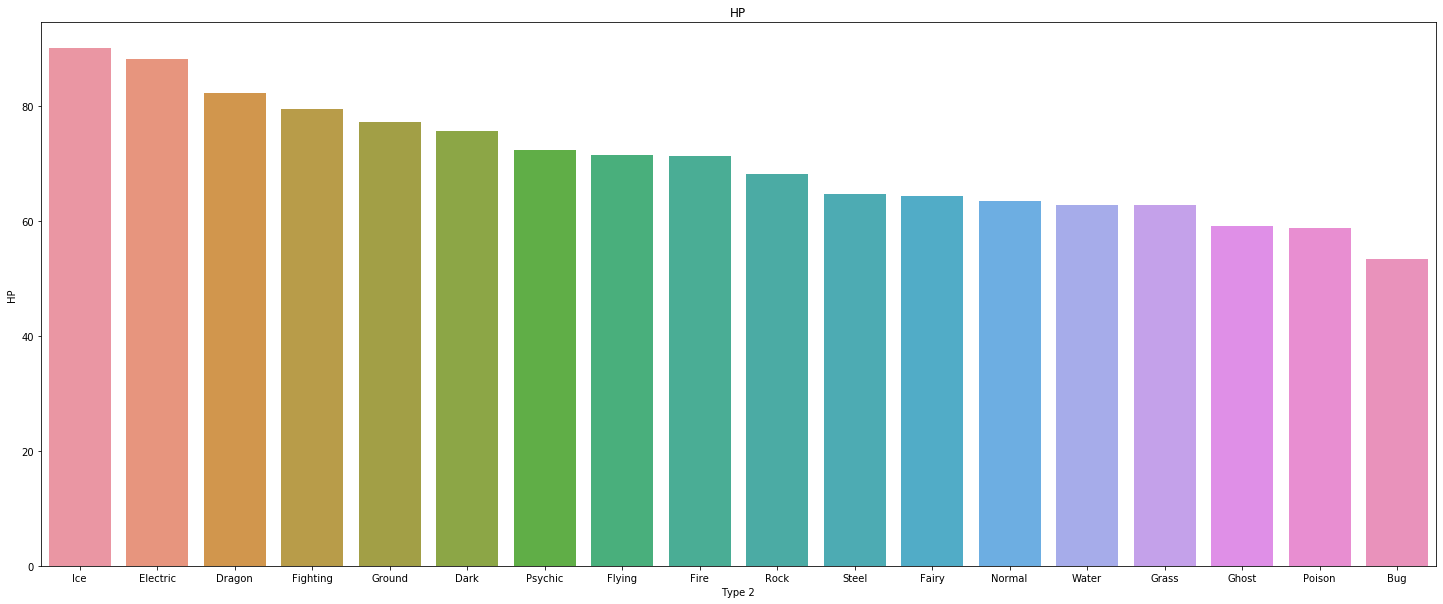

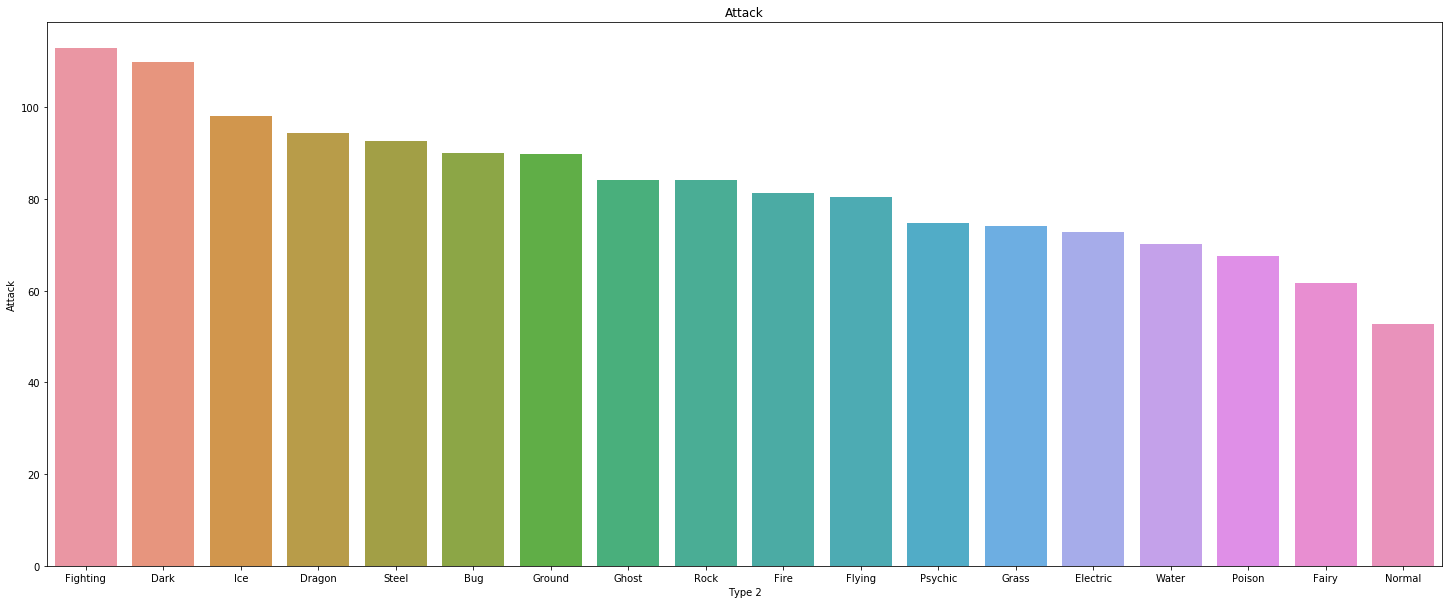

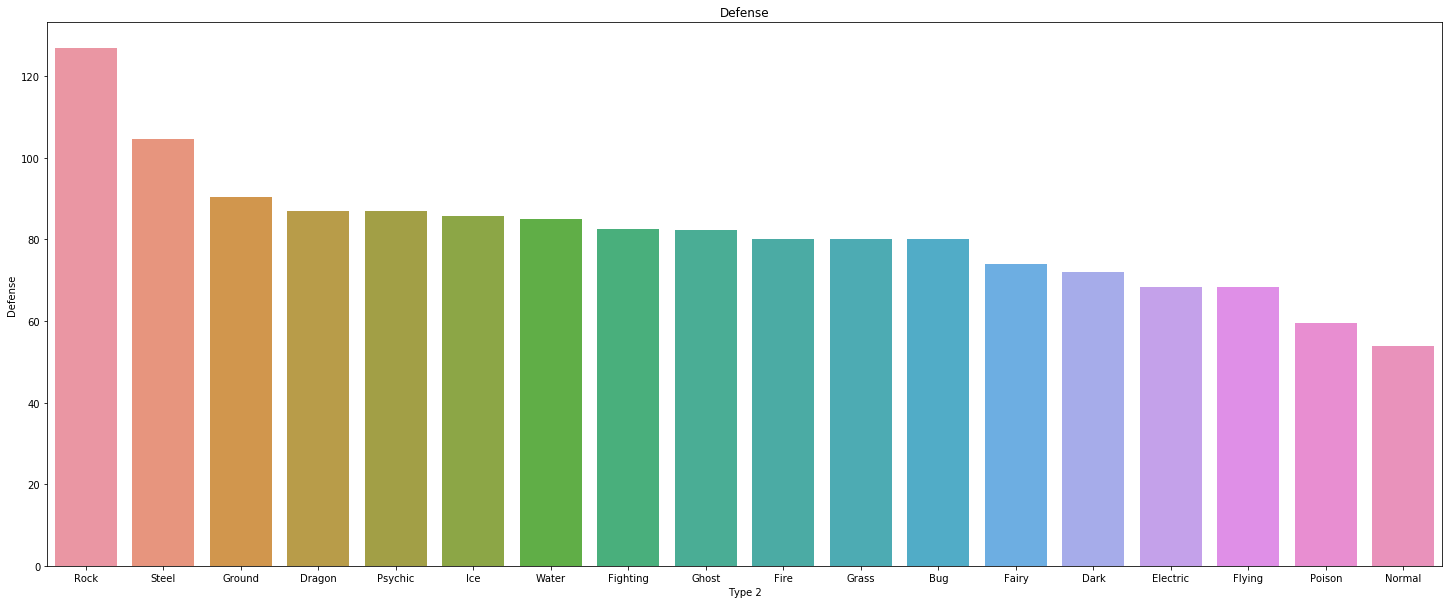

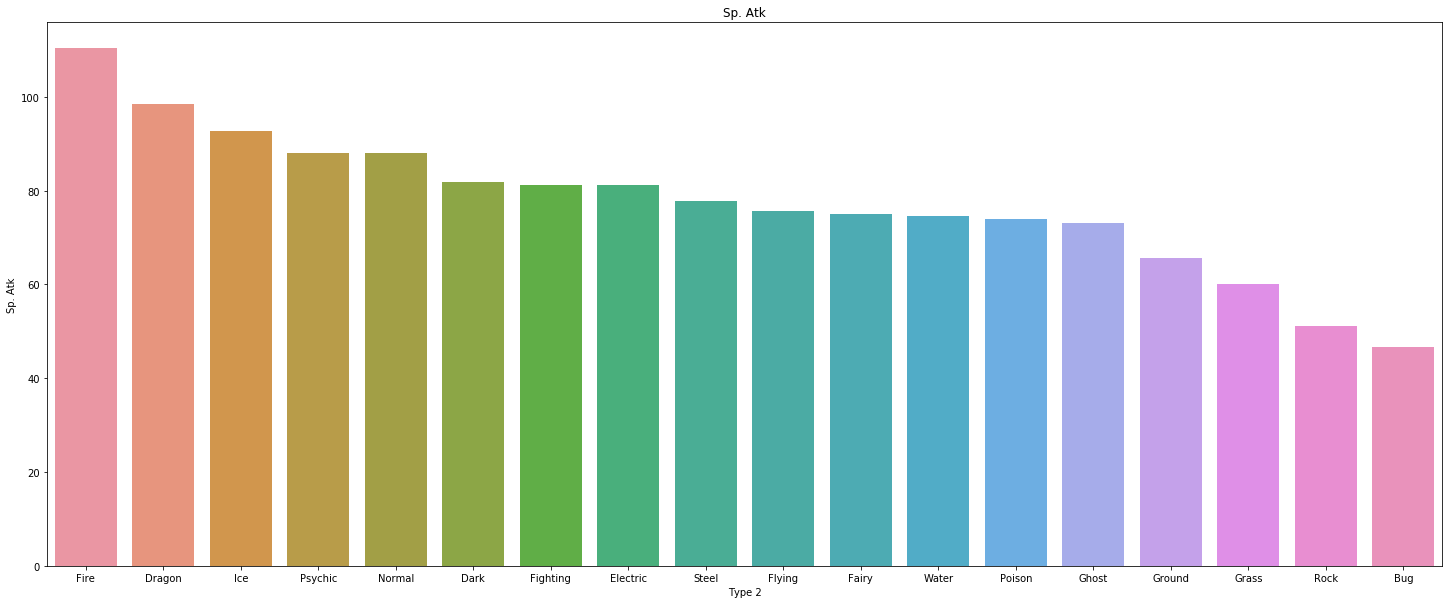

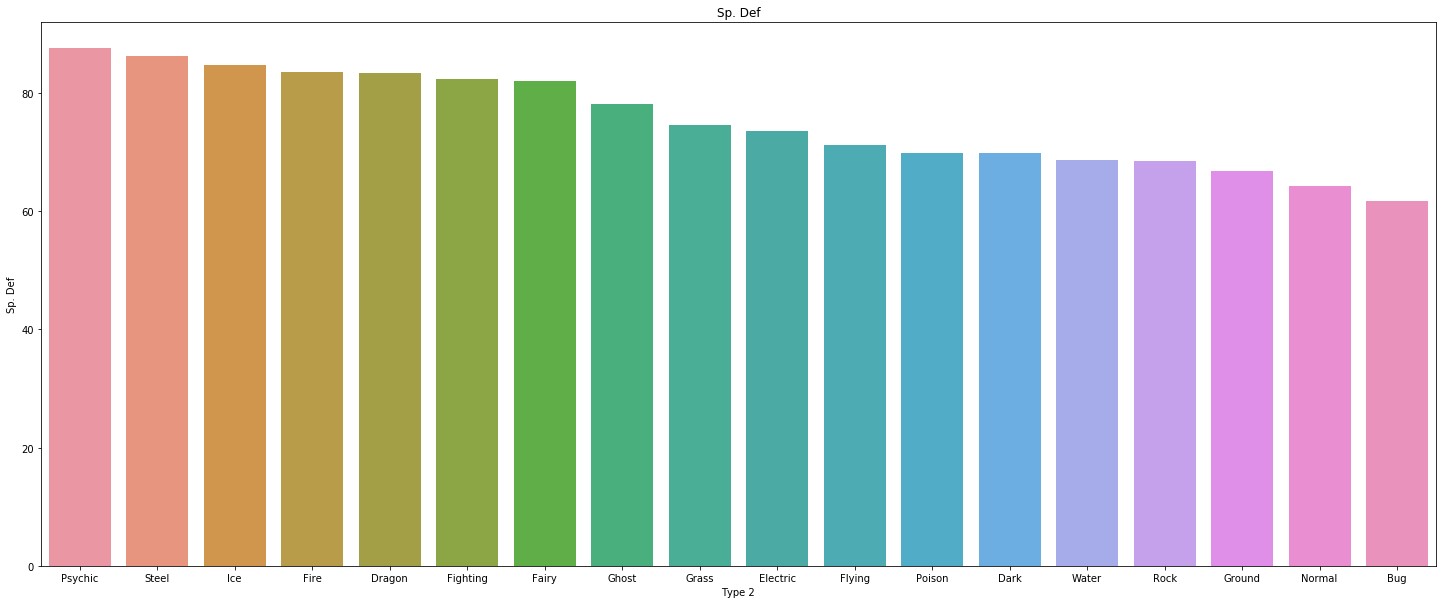

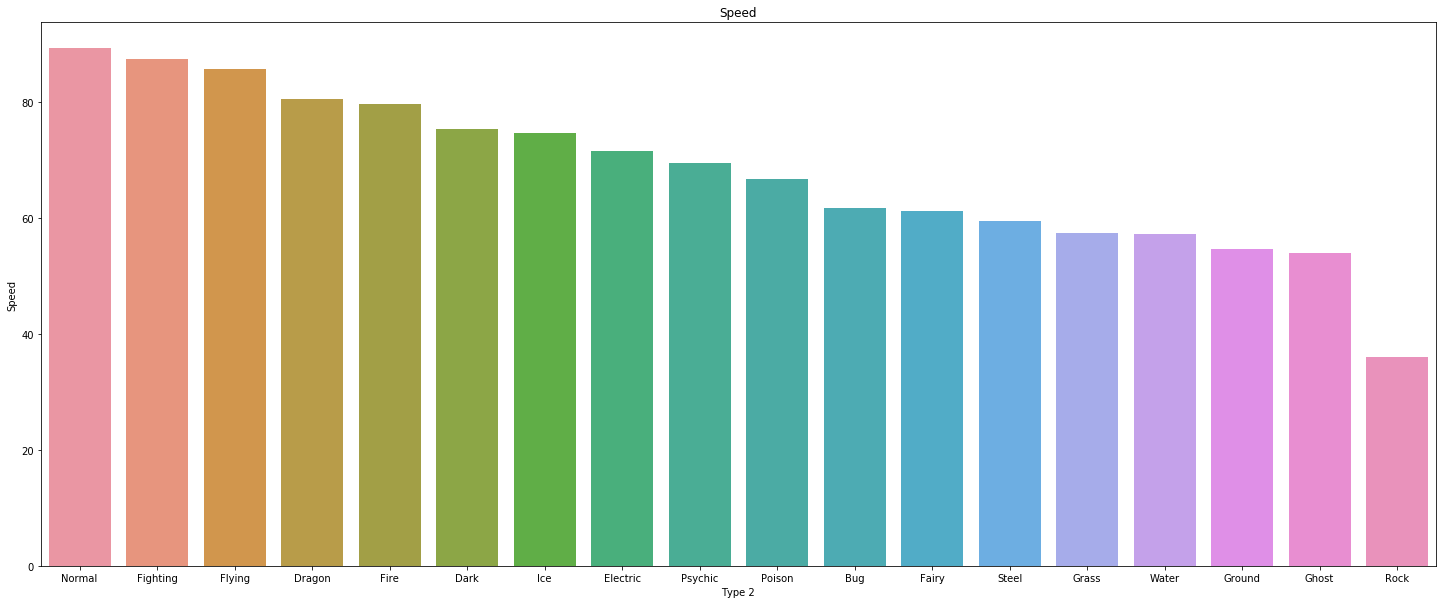

In [12]:
stat_feats = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
for i in stat_feats:
    df_ordered = df_mean(df, 'Type 2', i)
    distrib_each_type(df_ordered, 'Type 2', i, '{}'.format(i))

What we can guess from those charts is that the dragon type has the highest total stats mean, and is almost always first in single stats, so it should be easier to classify a dragon type 1 pokemon. We can also see that some type behave very differently when they are the first or the secondary type. For example, Type 1 Normal Pokemon have an average Speed of 70 whereas Type 2 Normal Pokemon have an average Speed of 90.
Also some types have very particular stat representation, indeed Type 2 Rock Pokemon are the slowest by a large amount and Steel Type 1  Pokemon are the one with the higher Defense, so these are elements that will allow our models to make predictions.

Now let's have a look at how Statistics behave over the whole dataset

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023F2AC8FEB8>,
      dtype=object)

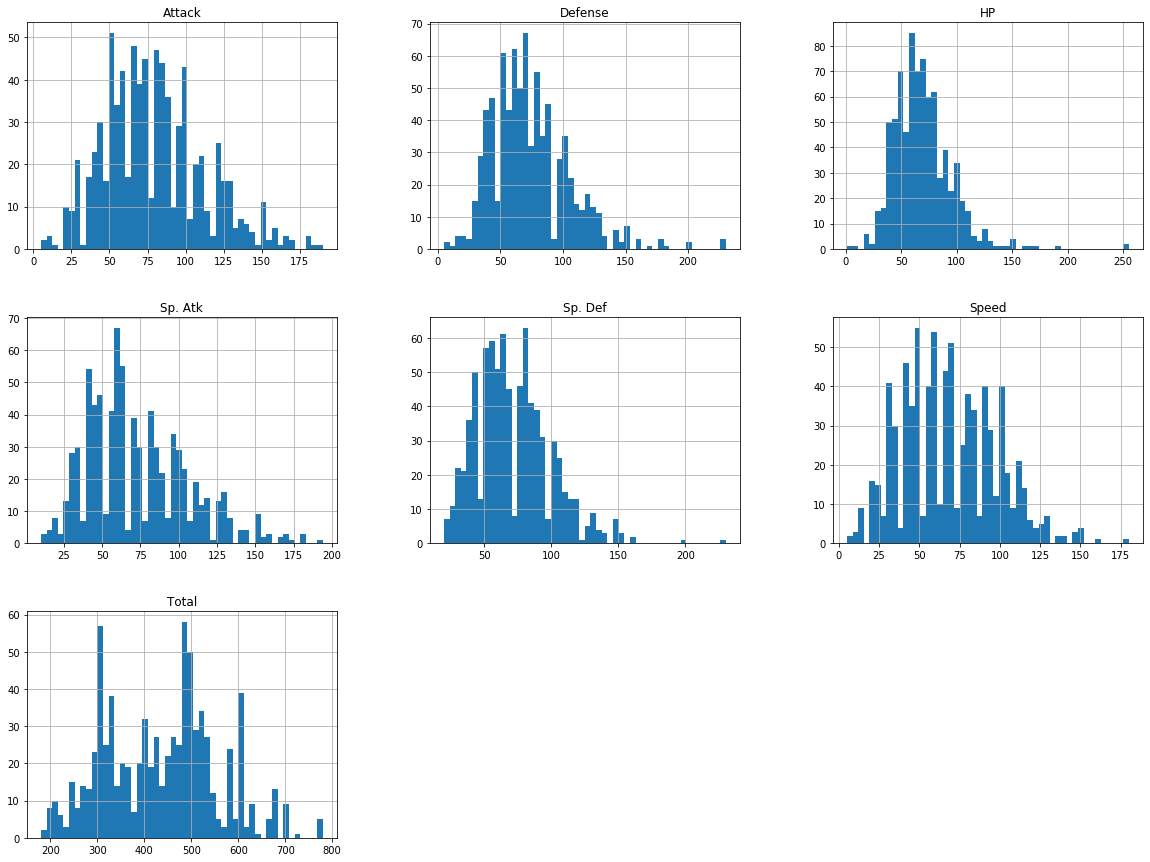

In [13]:
df[stat_feats].hist(bins=50, figsize = (20,  15))

It looks like most of the statistics follow a Normal distribution, exectp the Total of statistics which is pretty noisy. Also all of the features have outliers.
Let's see if those outliers are significients.

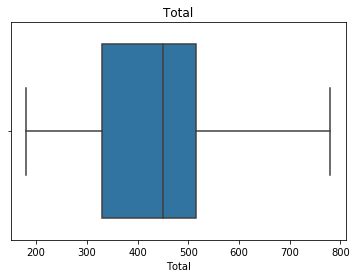

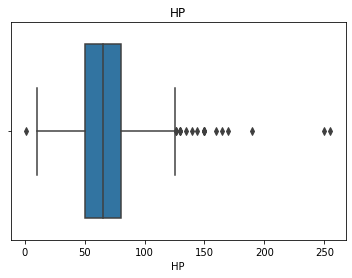

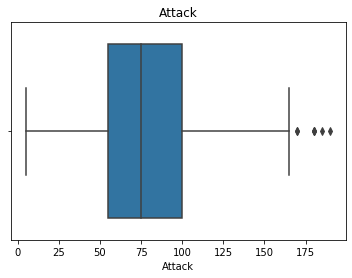

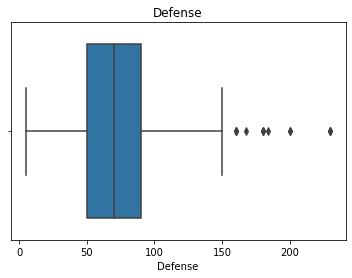

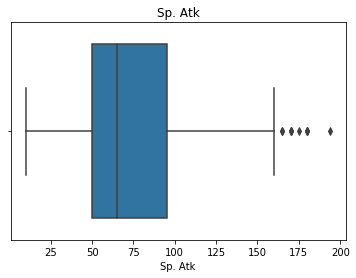

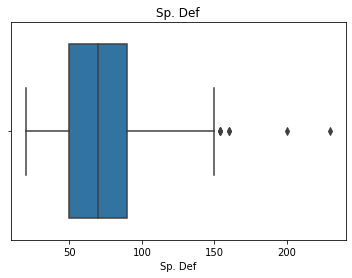

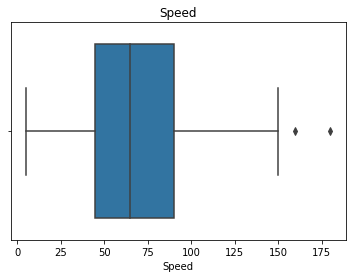

In [14]:
outlied_features = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']

for i, col in enumerate(outlied_features):
    sns.boxplot(df[col])
    plt.title(col)
    plt.show()


The only problematic feature seems to be the HP values, but for the moment we will let them as they are.

In [15]:
df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [16]:
df['Legendary'].value_counts()

False    735
True      65
Name: Legendary, dtype: int64

We need to encode the legendary values to make sure we work with only numerical features. we will also need to do the same thing for each Pokemon Type.
First the Legendary column

In [17]:
df['Legendary'] = df['Legendary'].replace(False, "0")
df['Legendary'] = df['Legendary'].replace(True, "1")
df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,0
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,0
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,0
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,0
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,0


In [18]:
types = ['Grass', 'Poison', 'Water', 'Rock', 'Ground', 'Dragon', 'Fairy', 'Bug', 'Ghost',
         'Dark', 'Psychic', 'Normal', 'Fighting', 'Electric', 'Flying', 'Ice', 'Steel', 'Fire']
count = 1
for i in types:
    df['Type 1'] = df['Type 1'].replace(i, count)
    df['Type 2'] = df['Type 2'].replace(i, count)
    count = count + 1
df['Type 2'].fillna("0", inplace = True) 
df

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,1,2,318,45,49,49,65,65,45,1,0
1,2,Ivysaur,1,2,405,60,62,63,80,80,60,1,0
2,3,Venusaur,1,2,525,80,82,83,100,100,80,1,0
3,3,VenusaurMega Venusaur,1,2,625,80,100,123,122,120,80,1,0
4,4,Charmander,18,0,309,39,52,43,60,50,65,1,0
5,5,Charmeleon,18,0,405,58,64,58,80,65,80,1,0
6,6,Charizard,18,15,534,78,84,78,109,85,100,1,0
7,6,CharizardMega Charizard X,18,6,634,78,130,111,130,85,100,1,0
8,6,CharizardMega Charizard Y,18,15,634,78,104,78,159,115,100,1,0
9,7,Squirtle,3,0,314,44,48,65,50,64,43,1,0


Because each Pokemon is sorted in the dataset by order and by generation and because legendary Pokemon are often in the end fo each generation, patterns are created naturally in our dataset. So we will the dataset

In [38]:
df_clean_type1 = df.reindex(np.random.permutation(df.index))
df_clean_type1

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
287,264,Linoone,12,0,420,78,70,61,50,61,100,3,0
578,519,Pidove,12,15,264,50,55,50,36,30,43,5,0
179,165,Ledyba,8,15,265,40,20,30,40,80,55,2,0
267,248,Tyranitar,4,10,600,100,134,110,95,100,61,2,0
128,119,Seaking,3,0,450,80,92,65,65,80,68,1,0
422,382,KyogrePrimal Kyogre,3,0,770,100,150,90,180,160,90,3,1
409,373,SalamenceMega Salamence,6,15,700,95,145,130,120,90,120,3,0
601,541,Swadloon,8,1,380,55,63,90,50,80,42,5,0
717,649,Genesect,8,17,600,71,120,95,120,95,99,5,0
323,299,Nosepass,4,0,375,30,45,135,45,90,30,3,0


## IV - Machine Learning

let's split our data into a training and a test set.

In [20]:
features = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary']
X = df_clean_type1[features]
y = df_clean_type1['Type 1']
print(X.shape)
print(y.shape)

(800, 9)
(800,)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(720, 9)
(720,)
(80, 9)
(80,)


## Random Forest

Let's start with a powerfull model to see how it behave on our dataset.

In [22]:
rf = RandomForestClassifier(n_estimators=51, random_state=42) # we choose 51 trees in order to avoid equality during the vote process
rf_score = cross_val_score(rf, X_train, y_train, cv=5, verbose=5)
print('Score on Validation Set : {}'.format(rf_score.mean()))

[CV]  ................................................................
[CV] .................................... , score=0.291, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.243, total=   0.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] .................................... , score=0.236, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.296, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.252, total=   0.1s
Score on Validation Set : 0.26367431651407025


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished


In [23]:
# accuracy on test set
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         1
           3       0.05      0.11      0.07         9
           4       0.25      0.40      0.31         5
           5       0.50      0.50      0.50         2
           6       0.25      0.33      0.29         3
           7       0.00      0.00      0.00         1
           8       0.67      0.60      0.63        10
           9       1.00      0.20      0.33         5
          10       0.00      0.00      0.00         4
          11       0.20      0.14      0.17         7
          12       0.30      0.30      0.30        10
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         5
          16       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         3
          18       0.40      0.33      0.36         6

    accuracy              

## Logistic regression

In [24]:
lr = LogisticRegression(random_state=42) 
lr_score = cross_val_score(lr, X_train, y_train, cv=5, verbose=5)
print('Score on Validation Set : {}'.format(lr_score.mean()))

[CV]  ................................................................
[CV] .................................... , score=0.199, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.223, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.243, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.275, total=   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


[CV] .................................... , score=0.259, total=   0.0s
Score on Validation Set : 0.23972223436009465


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


In [25]:
# accuracy on test set
lr.fit(X_train, y_train)
lr_predictions = lr.predict(X_test)
print(classification_report(y_test, lr_predictions,))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         1
           3       0.12      0.33      0.17         9
           4       0.14      0.20      0.17         5
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         1
           8       0.38      0.30      0.33        10
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         4
          11       0.29      0.29      0.29         7
          12       0.20      0.40      0.27        10
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         5
          16       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         3
          18       0.50      0.17      0.25         6

    accuracy              

## Support Vector classification

In [26]:
clf_svc = Pipeline ((
            ("poly_features", PolynomialFeatures(degree = 3)),
            ("scaler",  StandardScaler()),
            ("svm_clf", LinearSVC(C = 10, loss = "hinge"))
))

svc_score = cross_val_score(clf_svc, X_train, y_train, cv=5, verbose=5)
print('Score on Validation Set : {}'.format(svc_score.mean()))


[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.238, total=   2.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] .................................... , score=0.236, total=   2.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s


[CV] .................................... , score=0.264, total=   2.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.8s remaining:    0.0s


[CV] .................................... , score=0.239, total=   2.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.1s remaining:    0.0s


[CV] .................................... , score=0.207, total=   2.4s
Score on Validation Set : 0.23712599970551654


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.5s finished


In [27]:
# accuracy on test set
clf_svc.fit(X_train, y_train)
clf_svc_predictions = clf_svc.predict(X_test)
print(classification_report(y_test, clf_svc_predictions))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         1
           3       0.20      0.22      0.21         9
           4       0.00      0.00      0.00         5
           5       0.33      0.50      0.40         2
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         1
           8       0.75      0.30      0.43        10
           9       0.67      0.40      0.50         5
          10       0.00      0.00      0.00         4
          11       0.40      0.29      0.33         7
          12       0.27      0.40      0.32        10
          13       0.00      0.00      0.00         1
          14       0.20      0.20      0.20         5
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         2
          17       0.25      0.33      0.29         3
          18       0.25    

### Conclusion:

By messing around with the randomness of the training set and test set and given the low number of rows in our dataset, the models used before change drastically depending on the training set. For example the random forest accuracy could go from 19% to 29% on the test set.

So the conclusion of this project is that we have interesting insights of how certain stat behave depending on the types of pokemon, but we can not create a good model that could allow us to make some predictions mostly because of the huge number of classes we have and the low number of rows. This model would be improved with some hyperparameters tuning that i tried but were a failure, resulting on overfitting models and overall low performances.